<a href="https://colab.research.google.com/github/OrangeSunProgramming/brain-tumor-classification/blob/main/models/snn_model/snn_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns


#Training directory
data_dir = '/content/drive/MyDrive/brain_tumor_classification_dataset/brain_tumor_dataset/brain_tumor_classification/Training'

#Parameters for image resizing and batch size
img_size = (180, 180)  #Resize all images to 180x180
batch_size = 32

#Loading the dataset using image_dataset_from_directory with validation split
train_dataset = image_dataset_from_directory(
    data_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int',  #integer labels
    validation_split=0.2,  #80% train, 20% validation
    subset='training',
    seed=123,  #For reproducibility
)

val_dataset = image_dataset_from_directory(
    data_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int',  #integer labels
    validation_split=0.2,  #Must be the same as the train split
    subset='validation',
    seed=123,  #For reproducibility
)

class_names = train_dataset.class_names

print(f"Class names: {class_names}")

#Normalizing the images (to scale pixel values between 0 and 1)
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

#Data augmentation
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
train_dataset = train_dataset.map(normalize_img).cache().prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(normalize_img).cache().prefetch(tf.data.AUTOTUNE)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.
Class names: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [ ]:
#SNN Layer
class SNNLayer(tf.keras.layers.Layer):
    def __init__(self, num_neurons, tau=10.0, threshold=1.0, dt=1.0):
        super(SNNLayer, self).__init__()
        self.num_neurons = num_neurons
        self.tau = tau  #Time constant for membrane potential decay
        self.threshold = threshold  #Firing threshold
        self.dt = dt  #Time step for simulation
        self.synaptic_weights = None  #Synaptic weights

    def build(self, input_shape):
        input_dim = input_shape[-1]  #Getting the last dimension, i.e., the number of features (channels)

        #Initializing synaptic weights with small random values
        self.synaptic_weights = self.add_weight(
            name="synaptic_weights",
            shape=(input_dim, self.num_neurons),
            initializer="random_normal",
            trainable=True
        )

    def call(self, inputs, training=False):
        #Computing the input current: I = X * W
        current_input = tf.matmul(inputs, self.synaptic_weights)

        #Creating the membrane potential tensor with shape (batch_size, num_neurons)
        #Initializing membrane potential dynamically based on batch size
        membrane_potential = tf.zeros([tf.shape(inputs)[0], self.num_neurons], dtype=tf.float32)

        #Update membrane potential: V = V - (1/tau) * V + I
        membrane_potential = membrane_potential - (membrane_potential / self.tau) * self.dt + current_input

        #Spike generation: Fire when the membrane potential exceeds the threshold
        spikes = tf.cast(membrane_potential >= self.threshold, tf.float32)

        #Reset potential after firing
        membrane_potential = membrane_potential * (1 - spikes)

        return spikes

#Spike-Timing Dependent Plasticity (STDP Layer)
class STDP(SNNLayer):
    def __init__(self, num_neurons, alpha_pos=0.005, alpha_neg=0.005, tau_pos=20.0, tau_neg=20.0, **kwargs):
        super(STDP, self).__init__(num_neurons, **kwargs)
        self.alpha_pos = alpha_pos
        self.alpha_neg = alpha_neg
        self.tau_pos = tau_pos
        self.tau_neg = tau_neg

    def build(self, input_shape):
        input_dim = input_shape[-1]  #Getting the last dimension, i.e., the number of features (channels)

        #Initializing synaptic weights as a trainable variable
        self.synaptic_weights = self.add_weight(
            name="synaptic_weights",
            shape=(input_dim, self.num_neurons),
            initializer="glorot_uniform",
            trainable=True
        )

    @tf.function
    def call(self, inputs, training=False):
        batch_size = tf.shape(inputs)[0]

        #Dynamically initializing spike time variables based on batch size
        pre_spike_times = tf.zeros([batch_size, self.num_neurons], dtype=tf.float32)
        post_spike_times = tf.zeros([batch_size, self.num_neurons], dtype=tf.float32)
        last_spike_time = tf.zeros([1], dtype=tf.float32)

        #Calling the parent class's call method for membrane potential and spike generation
        spikes = super(STDP, self).call(inputs)

        #Simulating time (accumulate time step by step)
        current_time = last_spike_time + self.dt

        #Applying STDP rule for weight updates
        spike_condition = tf.cast(spikes > 0, tf.float32)
        delta_w = self.alpha_pos * tf.exp(-(current_time - pre_spike_times) / self.tau_pos) - \
                  self.alpha_neg * tf.exp(-(current_time - post_spike_times) / self.tau_neg)

        #Flatten inputs to match the dimensions of synaptic weights
        inputs_flat = tf.reshape(inputs, [batch_size, -1])

        #Applying weight updates based on STDP
        weight_updates = tf.matmul(tf.transpose(inputs_flat), delta_w)
        self.synaptic_weights.assign_add(weight_updates)

        return spikes

In [ ]:
#SNN Model definition
def build_snn_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        STDP(180),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model


In [ ]:
def spike_loss(y_true, y_pred):
    #Convert spike patterns to counts and compute loss
    spike_count_true = tf.reduce_sum(y_true, axis=-1)
    spike_count_pred = tf.reduce_sum(y_pred, axis=-1)
    return tf.reduce_mean(tf.square(spike_count_true - spike_count_pred))

In [ ]:
#Creating the model
model = build_snn_model(input_shape=(180, 180, 3), num_classes=4)

#Learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))

#Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=spike_loss,  #Using custom spike loss function
              metrics=["accuracy"])

#Model's Summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 89, 89, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 43, 43, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 20, 20, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ stdp (STDP)                          │ (None, 180)                 │       9,216,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          11,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,321,988 (35.56 MB)

 Trainable params: 9,321,540 (35.56 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
#Early stopping and model checkpoint
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_loss", mode="auto")
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/brain_tumor_classification_dataset/Brain Tumor GitHub/SNN Model/Checkpoints/best_model.keras', monitor='val_loss', save_best_only=True, mode='auto')

#Training the model
history = model.fit(train_dataset, epochs=100, validation_data=val_dataset, callbacks=[early_stopping, checkpoint, lr_schedule])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'synaptic_weights'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 402s 6s/step - accuracy: 0.2561 - loss: 2095.9382 - val_accuracy: 0.2857 - val_loss: 2023.9965 - learning_rate: 1.0000e-05
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 107s 898ms/step - accuracy: 0.2846 - loss: 2095.9382 - val_accuracy: 0.2857 - val_loss: 2023.9965 - learning_rate: 1.1220e-05
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 64s 895ms/step - accuracy: 0.2498 - loss: 2095.9382 - val_accuracy: 0.2857 - val_loss: 2023.9965 - learning_rate: 1.2589e-05
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 64s 891ms/step - accuracy: 0.2136 - loss: 2095.9382 - val_accuracy: 0.2892 - val_loss: 2023.9965 - learning_rate: 1.4125e-05
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 65s 902ms/step - accuracy: 0.2458 - loss: 2095.9382 - val_accuracy: 0.2927 - val_loss: 2023.9965 - learning_rate: 1.5849e-05
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 65s 902ms/step - accuracy: 0.2410 - loss: 2095.9382 - val_accuracy: 0.3066 - val_loss: 2023.9965 - learning_rate: 1.7783e-05


In [ ]:
#Evaluating the model
val_loss, val_acc = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 652ms/step - accuracy: 0.3191 - loss: 1900.9418
Validation Loss: 2023.9964599609375, Validation Accuracy: 0.30662021040916443


In [ ]:
#Saving the training history
import pandas as pd
snn_model_history = pd.DataFrame(history.history)
snn_model_history.to_csv("/content/drive/MyDrive/brain_tumor_classification_dataset/Brain Tumor GitHub/SNN Model/snn_model_history.csv")

print("Training history saved!")

Training history saved!


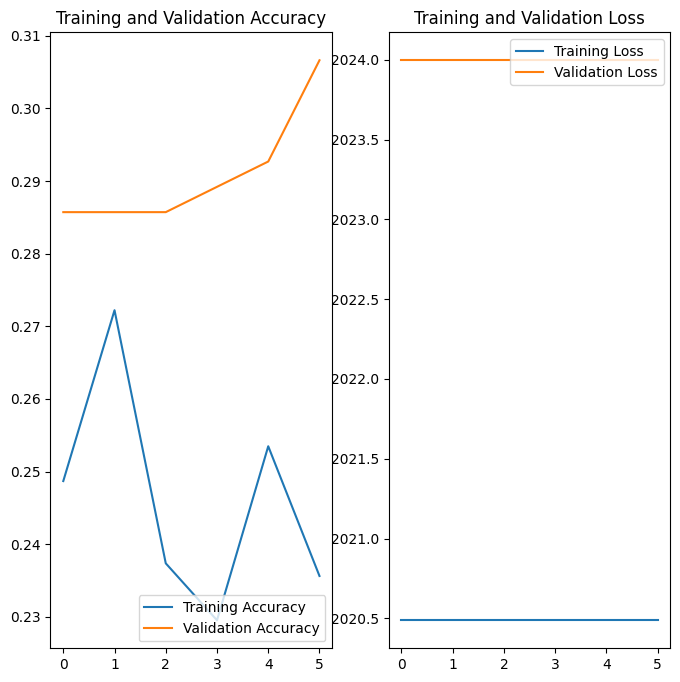

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history["loss"]))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig("/content/drive/MyDrive/brain_tumor_classification_dataset/Brain Tumor GitHub/SNN Model/snn_model_results.png")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


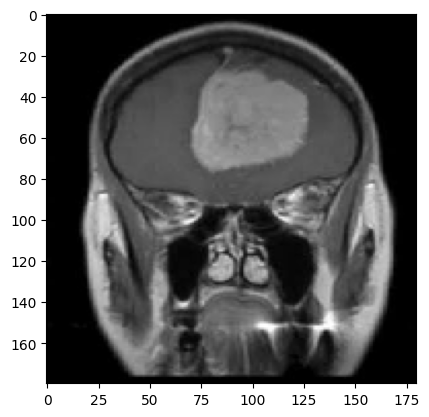

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_image(image_path, model):
    #Loading and preprocessing the image
    img = image.load_img(image_path, target_size=(180, 180))
    img_array = image.img_to_array(img)  #Convert to array
    img_array = np.expand_dims(img_array, axis=0)  #Add batch dimension
    img_array = img_array / 255.0  #Rescale image as done during training

    #Making predictions
    predictions = model.predict(img_array)

    #Displaying the image and predicted class
    plt.imshow(img)
    plt.show()

    print("Predicted class:", class_names[np.argmax(predictions)])

#Predicting a single image
predict_image("/content/drive/MyDrive/brain_tumor_classification_dataset/brain_tumor_dataset/brain_tumor_classification/Testing/meningioma_tumor/image(21).jpg", model)

Predicted class: glioma_tumor
Found 394 files belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


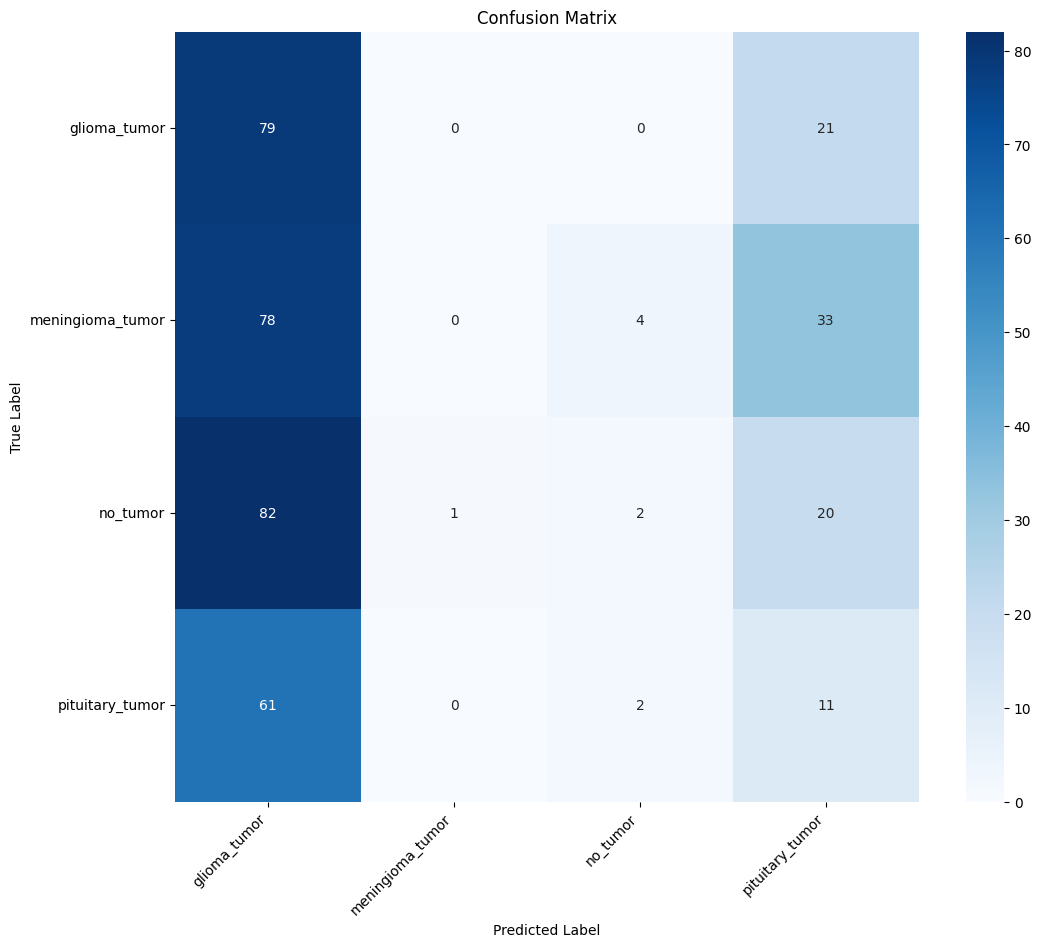

                  precision    recall  f1-score   support

    glioma_tumor       0.26      0.79      0.40       100
meningioma_tumor       0.00      0.00      0.00       115
        no_tumor       0.25      0.02      0.04       105
 pituitary_tumor       0.13      0.15      0.14        74

        accuracy                           0.23       394
       macro avg       0.16      0.24      0.14       394
    weighted avg       0.16      0.23      0.14       394



In [ ]:
#Load the testing dataset
test_dataset_dir = "/content/drive/MyDrive/brain_tumor_classification_dataset/brain_tumor_dataset/brain_tumor_classification/Testing"
test_ds = tf.keras.utils.image_dataset_from_directory(test_dataset_dir, image_size=(180, 180), batch_size=batch_size)

#Get the true labels and predicted labels
true_labels = []
predicted_labels = []

for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(labels.numpy())

#Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)

#Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.savefig("/content/drive/MyDrive/brain_tumor_classification_dataset/Brain Tumor GitHub/SNN Model/snn_confusion_matrix.png")
plt.show()

report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)